In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from math import factorial
from scipy.special import eval_genlaguerre
import matplotlib

In [2]:
# Jonah's conventions for the unit cell and stuff
q1 = -np.array([0.0,-1.0],dtype = complex)  # lattice vectors in the Q lattice
q2 = -np.array([np.sqrt(3)/2,0.5],dtype = complex)
q3 = -np.array([-np.sqrt(3)/2,0.5],dtype = complex)

b1 = q2 - q1
b2 = q3 - q1

# Lattice vectors
a1 = (2./3)*np.array([-np.sqrt(3)/2,-0.5],dtype = complex)  # lattice vectors in the Q lattice
a2 = (2./3)*np.array([np.sqrt(3)/2,-0.5],dtype = complex)  # lattice vectors in the Q lattice

# special points in the MBZ
kpt = -q3 # The K point
gpt = np.array([0.0,0.0], dtype = complex) # The Gamma point
mpt = -q3 - 0.5*q1 # The M point
mmpt = -mpt
kppt = -kpt

# 3 parameters  
w0 = 0.8/np.sqrt(3)/1.114
w1 = 1./np.sqrt(3)/1.114
vFkth = 110.0*np.sqrt(3)*1.114 # at 1.17 degrees

In [3]:
ax1, ay1 = a1
ax2, ay2 = a2
omega = abs(ax1 * ay2 - ay1 * ax2)
    
z1 = (ax1 + 1.0j*ay1)/np.sqrt(omega)
z1bar = (ax1 - 1.0j*ay1)/np.sqrt(omega)
z2 = (ax2 + 1.0j*ay2)/np.sqrt(omega)
z2bar = (ax2 - 1.0j*ay2)/np.sqrt(omega)

In [4]:
def distance(a,b): # finds the distance between two complex vectors
    x0, y0 = np.real(a) # because they were complex, cast to real and then unpack to get x, y
    x1, y1 = np.real(b)
    return(np.sqrt((x0-x1)**2 + (y0 - y1)**2))

In [5]:
formFactors1 = np.load('TBG_Form_Factors_G1.npy')
formFactors2 = np.load('TBG_Form_Factors_G2.npy')

def calculateMatrixElement1(k,m,n):
    G1 = 1.
    G2 = 0. 
    k1 = 2*np.pi*np.dot(a1,k)
    k2 = 2*np.pi*np.dot(a2,k)
    return(np.exp(1.0j*(k1*G2-k2*G1)) * formFactors1[m][n])

def calculateMatrixElement2(k,m,n):
    G1 = 0.
    G2 = 1. 
    k1 = 2*np.pi*np.dot(a1,k)
    k2 = 2*np.pi*np.dot(a2,k)
    return(np.exp(1.0j*(k1*G2-k2*G1)) * formFactors2[m][n])

In [32]:
# First calculate the t-matrices, which do not change for different k-points, and kinetic terms

num_landau = 160
energy = np.sqrt((3*np.sqrt(3))/(2*np.pi))
kinetic_up1 = np.zeros((num_landau,num_landau),dtype = complex)
kinetic_up2 = np.zeros((num_landau,num_landau),dtype = complex)
kinetic_down1 = np.zeros((num_landau,num_landau),dtype = complex)
kinetic_down2 = np.zeros((num_landau,num_landau),dtype = complex)
zero_mat = np.zeros((num_landau,num_landau),dtype = complex)

kinetic = np.zeros((4*num_landau,4*num_landau),dtype = complex)

spurious_killer = np.zeros((num_landau,num_landau),dtype = complex)
spurious_killer[num_landau-1,num_landau-1] = 1000.

# First we add the kinetic terms
for m in range(num_landau): 
    for n in range(num_landau):
        if m == n+1:
            kinetic_up1[m][n] = energy*np.sqrt(n+1)
            kinetic_down1[m][n] = energy*np.sqrt(n+1)
        if m == n-1:
            kinetic_up2[m][n] = energy*np.sqrt(n)
            kinetic_down2[m][n] = energy*np.sqrt(n)
        
# The shift    
for m in range(num_landau):
    kinetic_up1[m][m] = 0.5j
    kinetic_up2[m][m] = -0.5j
    kinetic_down1[m][m] = -0.5j
    kinetic_down2[m][m] = 0.5j

kinetic1 = np.block([[spurious_killer, kinetic_up1],[kinetic_up2,spurious_killer]])
kinetic2 = np.block([[spurious_killer,kinetic_down1],[kinetic_down2,spurious_killer]])

t1 = np.matrix([[w0, w1],[w1,w0]],dtype=complex)
t2 = np.matrix([[w0, w1*np.exp(-2.0j*np.pi/3.)],[w1*np.exp(2.0j*np.pi/3.),w0]],dtype=complex)
t3 = np.matrix([[w0, w1*np.exp(-4.0j*np.pi/3.)],[w1*np.exp(4.0j*np.pi/3.),w0]],dtype=complex)

iden = np.identity(num_landau,dtype=complex)                                                
                                                
T1_mat = np.kron(t1,iden)
T2_mat = np.kron(t2,formFactors1[:num_landau,:num_landau])
T3_mat = np.kron(t3,formFactors2[:num_landau,:num_landau])

def generateHam(k):
    k1 = 2*np.pi*np.dot(a1,k)
    k2 = 2*np.pi*np.dot(a2,k)
    t_mat = np.zeros((2*num_landau,2*num_landau),dtype = complex)
    t_mat = T1_mat + np.exp(-1.0j*k2) * T2_mat + np.exp(1.0j*k1) * T3_mat
    #hamiltonian = np.block([[kinetic_1+kinetic_shift_1, t_mat.conj().T], [t_mat, kinetic_2+kinetic_shift_2]])
    #hamiltonian = np.block([[kinetic_1+5*kinetic_quad+5*kinetic_quad_shift, t_mat.conj().T], \
                            #[t_mat, kinetic_2+5*kinetic_quad+5*kinetic_quad_shift]])
    hamiltonian = np.block([[kinetic1, t_mat.conj().T], \
                            [t_mat, kinetic2]])
    return(vFkth*hamiltonian)

In [33]:
# generate path in MBZ to plot
numpoints = 50 # path divided into pieces.  There are 3*numpoints, from K to Gamma to M to K
g_to_k = [gpt * (1.0 - (t+0.0)/numpoints) + kpt * ((t+0.0)/numpoints) for t in range(numpoints)] # from K to Gamma
k_to_m = [kpt * (1.0 - (t+0.0)/numpoints) + mpt * ((t+0.0)/numpoints) for t in range(numpoints)] # from Gamma to M
m_to_g = [mpt * (1.0 - (t+0.0)/numpoints) + gpt * ((t+0.0)/numpoints) for t in range(numpoints)] # from M to K
g_to_mm = [gpt * (1.0 - (t+0.0)/numpoints) + mmpt * ((t+0.0)/numpoints) for t in range(numpoints)]
mm_to_kp = [mmpt * (1.0 - (t+0.0)/numpoints) + kppt * ((t+0.0)/numpoints) for t in range(numpoints)]

list_of_points = g_to_k+k_to_m+m_to_g+g_to_mm+mm_to_kp # + means append here, so the list is 3*numpoints long
array_of_points = np.array(list_of_points) # to numpy array

# some intervals between points are longer than others.  Fix by normalizing by length
len_k = [0.0] # this is the x-axis of the band structure plot.  starting at 0,
prev_k = 0.0
for i in range(len(list_of_points) - 1):
    prev_k += distance(array_of_points[i+1],array_of_points[i]) # add distances cumulatively
    len_k.append(prev_k)

In [34]:
listOfEigenvals = []  # will hold all the eigenvalues.  Probably would be faster with sparse matrices and Lanczos
for i, k_vec in enumerate(list_of_points):  # for each k-point in the path
    ham = generateHam(k_vec)  # build Hk
    eigenvals, eigenvecs = np.linalg.eigh(ham)  # find eigenvalues
    listOfEigenvals.append(eigenvals)  # add to list

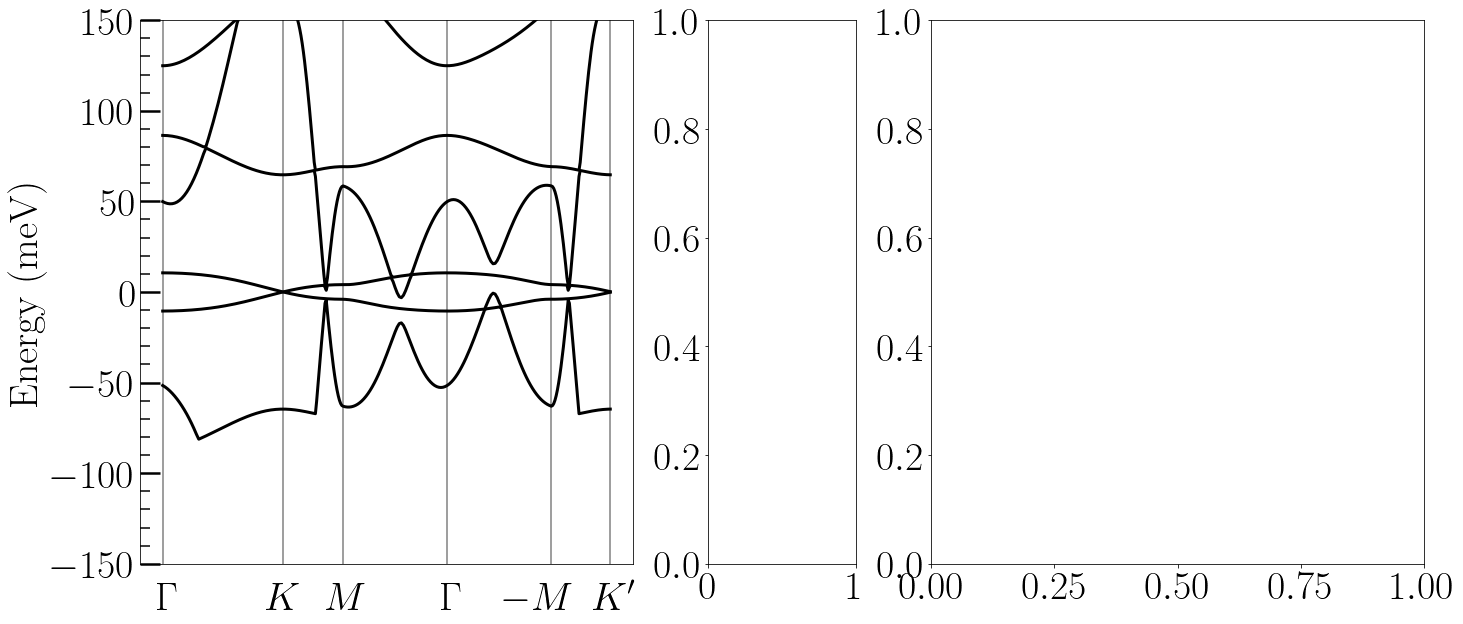

In [35]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import ticker

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 40}

matplotlib.rc('font', **font)
matplotlib.rc('text',usetex=True)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(23, 10), gridspec_kw={'width_ratios': [1,0.3,1]})
plt.subplots_adjust(wspace=0.2)

axes[0].get_xaxis().set_visible(False)
axes[0].tick_params(direction="in",width=2.5, length=180)

arrayOfEigenvals=np.array(listOfEigenvals)# take the 8 bands closest to 0 energy
axes[0].axvline(x=len_k[0],color='gray')
axes[0].text(len_k[0]-.05,-175,r'$\Gamma$',rotation=0)
axes[0].axvline(x=len_k[50],color='gray')
axes[0].text(len_k[50]-.15,-175,r'$K$',rotation=0)
axes[0].axvline(x=len_k[100],color='gray')
axes[0].text(len_k[100]-.15,-175,r'$M$',rotation=0)
axes[0].axvline(x=len_k[150],color='gray')
axes[0].text(len_k[150]-.05,-175,r'$\Gamma$',rotation=0)
axes[0].axvline(x=len_k[200],color='gray')
axes[0].text(len_k[200]-.4,-175,r'$-M$',rotation=0)
axes[0].axvline(x=len_k[249],color='gray')
axes[0].text(len_k[249]-.15,-175,r"$K'$",rotation=0)
axes[0].set_ylim([-150, 150])

#axes[0].xlim([-0.075,len_k[249]+.075])
#plt.ylim([0,2*np.pi])

axes[0].set_ylabel(r'Energy (meV)')
for i in range(316,324):
    axes[0].plot(len_k, arrayOfEigenvals[:,i],linewidth=3,color='black')
    

axes[0].get_yaxis().set_major_locator(MultipleLocator(50))
axes[0].get_yaxis().set_minor_locator(MultipleLocator(10))
axes[0].tick_params(which='major',direction="in",width=2.5, length=20)
axes[0].tick_params(which='minor',direction="in",width=1.5, length=10)

#plt.savefig('PH_term_1-17.pdf',bbox_inches='tight')

In [ ]:
totalEigs = []
listOfPointsForBZ = []

for i in range(25):
    for j in range(25):
        k_vec = b1*j/25.0+b2*i/25.0
        ham = generateHam(k_vec)  # build Hk
        eigenvals, eigenvecs = np.linalg.eigh(ham)  # find eigenvalues
        totalEigs.append(eigenvals[318:324])  
        listOfPointsForBZ.append(k_vec)
        
arrayOfPointsForBZ = np.array(listOfPointsForBZ)
arrayOfEigsForBZ = np.array(totalEigs)

In [ ]:
def plotHexagon(points,l1,l2):
    # first, translate the states into the hexagon
    # define the unit vectors that define the hexagon
    dist = np.linalg.norm(l1)
    hex1 = l1/np.linalg.norm(l1)
    hex2 = l2/np.linalg.norm(l2)
    l3 = l2 - l1
    hex3 = l3/np.linalg.norm(l3)
    newPoints = []
    for coords in points:
        len1 = np.dot(coords, hex1)
        len2 = np.dot(coords, hex2)
        len3 = np.dot(coords, hex3)
        if len1 < 0.5*dist+0.00005 and len2 < 0.5*dist+0.00005:
            newPoints.append(coords)
        elif len1 > dist and len2 > dist:
            newPoints.append(coords-l1-l2)
        elif len3 > 0:
            newPoints.append(coords-l2)
        else:
            newPoints.append(coords-l1)
            
    return(np.array(newPoints))

def inHexagon(pointsx,pointsy,l1,l2):
    # first, translate the states into the hexagon
    # define the unit vectors that define the hexagon
    matrixOfVals = np.zeros(np.shape(pointsx))
    dist = np.linalg.norm(l1)
    hex1 = l1/np.linalg.norm(l1)
    hex2 = l2/np.linalg.norm(l2)
    l3 = l2 - l1
    hex3 = l3/np.linalg.norm(l3)
    inside = []
    for i in range(len(pointsx)):
        for j in range(len(pointsx[0])):
            matrixOfVals[i][j] = 0
            coords = np.array([pointsx[i][j],pointsy[i][j]])
            len1 = np.dot(coords, hex1)
            len2 = np.dot(coords, hex2)
            len3 = np.dot(coords, hex3)
            if len1 < np.sqrt(3)/2 and len1 > -np.sqrt(3)/2:
                if len2 < np.sqrt(3)/2 and len2 > -np.sqrt(3)/2:
                    if len3 < np.sqrt(3)/2 and len3 > -np.sqrt(3)/2:
                        matrixOfVals[i][j] = 1.0
    return(matrixOfVals)

import scipy.interpolate

newCoords = plotHexagon(np.real(arrayOfPointsForBZ),b1,b2)
x = newCoords[:,0]
y = newCoords[:,1]
z = arrayOfEigsForBZ[:,4]
pts = np.real(newCoords)
# Set up a regular grid of interpolation points
xi, yi = np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100)
xi, yi = np.meshgrid(xi, yi)
# Interpolate
newguess = scipy.interpolate.NearestNDInterpolator(pts,z)
zi = np.multiply(inHexagon(xi,yi,b1,b2),newguess(xi, yi))
plt.imshow(zi, vmin=z.min(), vmax=z.max(), origin='lower',
           extent=[x.min(), x.max(), y.min(), y.max()])
#plt.scatter(x, y, c=z)
plt.colorbar()
#plt.savefig('flat_twist_1_heatmap.png')